# Automatic Cyberbulling Detection

The goal of the assignment is to build a machine learning model for Automatic
cyberbullying detection, Task 6-2: Type of harmfulness
http://2019.poleval.pl/index.php/tasks/task6 and deploy it as a simple yet well designed service.

## Training
Training supervised deep networks requires a lot of data. However, Poleval trainig set for Task 6.2 contains only ~10K wors of labeled data, even less whent counting only tagged sentences (see above). For that reason I have decided to use a pretrained language model for Polish, more specifically HerBERT Base model. 

Using pretrained transformer models for fine-tuning models for a specific task is well documented and implemented in Python `transformers` package. In our case we have a sequence classification task (one can only choose one label for sentence), so our inputs are numerical tokens and outputs are lables. Transformers package delivers a conveniant way to automate this task for us, including downloading model and tokenizing data.

When tokenizing BERT-type language models it is recommended to use a ML tokenizer such as one used by authors of the model since tokenization for those models requires subword units and is a fairly [complex process](https://arxiv.org/pdf/1508.07909.pdf). Again, we can use a pretrained tokenizer with a little help from authors of `transformers` package.

### Training data
First, let's have a look at data. I choose to represent my data as pandas frames if possible for simplicity of processing and compatibility with many tools from pydata world. Complying to keeping everything as a pd.DataFrame actually allows to scale to out-of-memory datasets and cluster computing using dask. Given a bigger dataset I would certainly use Dask to leverage all cores and possibly many machines for data processing and training (using dask-pytorch connector).

In [1]:
%load_ext autoreload
%autoreload 2
%set_env TOKENIZERS_PARALLELISM=0
import pandas as pd
import sidetable
import numpy as np

ANON_TAG_REPLACEMENT = ""

env: TOKENIZERS_PARALLELISM=0


In [2]:

def read_dataset(text_path: str, tags_path: str):
    txt = pd.read_csv(text_path, delimiter="\n", header=None, names=("inputs",), dtype="string")
    tag = pd.read_csv(tags_path, delimiter="\n", header=None, names=("tag",))
    merged = pd.concat([txt, tag], axis=1)
    assert len(txt) == len(merged)
    return merged

train_df = read_dataset("../../data/poleval6/train/training_set_clean_only_text.txt", "../../data/poleval6/train/training_set_clean_only_tags.txt")
assert pd.isnull(train_df).sum().sum() == 0
num_labels = len(train_df.tag.unique())
train_df

inputs  tag
0      Dla mnie faworytem do tytułu będzie Cracovia. ...    0
1      @anonymized_account @anonymized_account Brawo ...    0
2      @anonymized_account @anonymized_account Super,...    0
3      @anonymized_account @anonymized_account Musi. ...    0
4        Odrzut natychmiastowy, kwaśna mina, mam problem    0
...                                                  ...  ...
10036   @anonymized_account Ty zagrasz? Nie wiedziałem 😉    0
10037  @anonymized_account @anonymized_account A VAR ...    0
10038  @anonymized_account @anonymized_account Szanow...    0
10039  @anonymized_account @anonymized_account @anony...    0
10040  @anonymized_account A wróżbita Maciej mówi że ...    0

[10041 rows x 2 columns]

We can see (as expected) that most sentences in the training set are tagged as non-harmful, much less as hate-speech or cyberbullying. Later we will apply weighted random sampling in attempt to address this issue.

In [3]:
train_df.stb.freq(['tag'])

tag  count    percent  cumulative_count  cumulative_percent
0    0   9190  91.524749              9190           91.524749
1    2    598   5.955582              9788           97.480331
2    1    253   2.519669             10041          100.000000

<AxesSubplot:xlabel='Harmfulness type', ylabel='Count'>

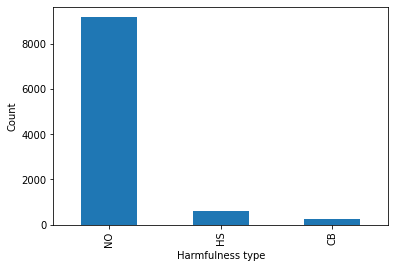

In [4]:
counts = train_df.tag.astype("category").cat.as_ordered().cat.rename_categories({0: "NO", 1: "CB", 2: "HS"}).value_counts()
counts.plot(kind='bar', xlabel="Harmfulness type", ylabel="Count")

The first thing we need to do with our dataset is to replace the result of anonymization process, `@anonymized_account` string that appears in the training data and when using subword-level tokenizer, we don't want any unnecessary attention over those tokens. Moreover, we want a model that understands if sentences are harmful from language itself  and that token is a result of a computing process applied natural language.

To see how much space we save by removing anonymization tag:

In [5]:
train_df["inputs"].apply(len).max()

214

In [6]:
if ANON_TAG_REPLACEMENT is not None:
    train_df["inputs"] = train_df["inputs"].str.replace("@anonymized_account", ANON_TAG_REPLACEMENT)


Let's check max length now.

In [7]:
train_df["inputs"].apply(len).max()

150

Next, I will load and apply a tokenizer used by the authors of HerBERT model

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased", truncation=False, padding=True)


In [9]:
sentences = train_df.inputs.to_list()
input_tokens = tokenizer.batch_encode_plus(
    sentences,
    padding='longest',
    add_special_tokens=True,
    return_tensors='pt'
    )

Check if shapes of output tokens make sense

In [10]:
{(k, v.shape) for k, v in input_tokens.items() } 

{('attention_mask', torch.Size([10041, 85])),
 ('input_ids', torch.Size([10041, 85])),
 ('token_type_ids', torch.Size([10041, 85]))}

Now, we must address train/validation split issue. Having so much little and so skewed label distribution, simple sampling 20% of train data into validation set will with high probability yield a training data without much labels other than 0. We will use stratified shuffle split from sklearn package.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
train_idx, val_idx = next(train_test_split.split(np.zeros(len(train_df)), train_df.tag))

Now, I can represent training data as Pytorch Dataset. One can implement below much more efficently by separating inputs beforehand 

In [12]:
import torch
from torch.utils.data import Dataset

class HarmfulnessDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.inputs.items()} # if necessary to satisfy torch warning
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HarmfulnessDataset(input_tokens,
                                   train_df["tag"].to_numpy())
assert len(train_dataset) == len(train_df)
# train_dataset = HarmfulnessDataset(train_df["inputs"][train_idx].to_numpy(),
#                                    train_df["tag"][train_idx].to_numpy())
# val_dataset = HarmfulnessDataset(train_df["inputs"][val_idx].to_numpy(),
#                                  train_df["tag"][val_idx].to_numpy())



And construct standard Pytorch Dataloader with shuffling each epoch and smaller batch size of (16, 32) recommended for training this kind of model. I will use small learning rate and AdamW optimizer from `transformers` (from [docs](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw-pytorch): "Implements Adam algorithm with weight decay fix as introduced in Decoupled Weight Decay Regularization."

In [13]:
from torch.utils.data import DataLoader
from transformers.optimization import AdamW
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)



Here I load model

In [14]:
from transformers import AutoModelForSequenceClassification



model = AutoModelForSequenceClassification.from_pretrained("allegro/herbert-base-cased", num_labels=num_labels)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

In [15]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"using {device} as device")

using cuda:0 as device


In [17]:
import tqdm

model.to(device)
model.train()

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for i, batch in enumerate(tqdm.tqdm(train_loader)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        if i % 10 == 0:
            print(f"Loss:{loss.item()}")
        optim.step()

model.eval()


  0%|                                                                                                                                                                                                                                                            | 0/5021 [00:00<?, ?it/s]/tmp/ipykernel_9701/1166232746.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx])
  0%|                                                                                                                                                                                                                                                            | 0/5021 [00:00<?, ?it/s]

Loss:1.3810570240020752


RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 1.96 GiB total capacity; 1.07 GiB already allocated; 131.50 MiB free; 1.21 GiB reserved in total by PyTorch)

In [ ]:
print(sentences[:5])
print(input_tokens)

In [ ]:

output = model(**input_tokens[0])

In [ ]:
## Introduction

In [ ]:
## Related work

In [ ]:
## Experimental Setup

In [ ]:
### Data

In [ ]:
### Data processing pipeline

In [ ]:
### Model

In [ ]:
### Evaluation

In [ ]:
### ML production pipeline deployment

In [ ]:
## Benchmarks